In [1]:
import os,re
import keras
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras import models
from keras.models import Model
from keras import Input
from keras.layers import Activation, Conv2D, MaxPooling2D, Flatten, Dense
from keras.callbacks import TensorBoard, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

Using TensorFlow backend.
/home/s-sato/anaconda3/envs/s-sato/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/s-sato/anaconda3/envs/s-sato/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/s-sato/anaconda3/envs/s-sato/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/s-sato/anacond

In [2]:
# 学習データとテストデータを取得する。
(_x_train_val, _y_train_val), (_x_test, _y_test) = mnist.load_data()
# 学習中の検証データがないので、train_test_split()を使って学習データ8割、検証データを2割に分割する。test_sizeが検証データの割合になっている。
_x_train, _x_val, _y_train, _y_val = train_test_split(_x_train_val, _y_train_val, test_size=0.2)

print("x_train   : ", _x_train.shape) # x_train   :  (48000, 28, 28)
print("y_train   : ", _y_train.shape) # y_train   :  (48000,)
print("x_val      : ", _x_val.shape) # x_val      :  (12000, 28, 28)
print("y_val      : ", _y_val.shape) # y_val      :  (12000,)
print("x_test    : ", _x_test.shape) # x_test    :  (10000, 28, 28)
print("y_test    : ", _y_test.shape) # y_test    :  (10000,)

11493376/11490434 [==============================] - 14s 1us/step
x_train   :  (48000, 28, 28)
y_train   :  (48000,)
x_val      :  (12000, 28, 28)
y_val      :  (12000,)
x_test    :  (10000, 28, 28)
y_test    :  (10000,)


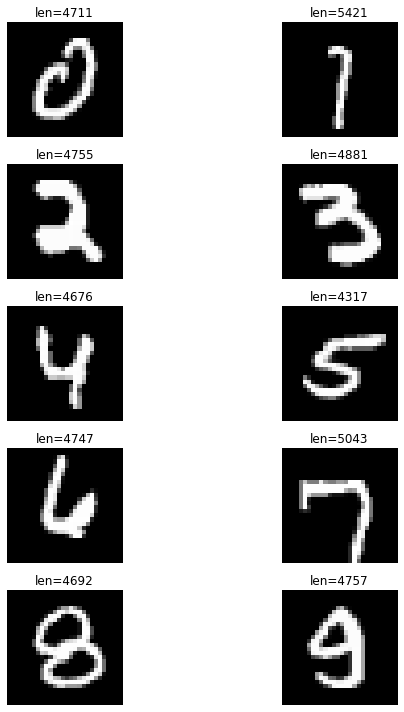

In [4]:
plt.figure(figsize=(10,10))

# MNISTの0から9の画像をそれぞれ表示する。
for i in range(10):
    data = [(x,t) for x, t in zip(_x_train, _y_train) if t == i]
    x, y = data[0]

    plt.subplot(5,2, i+1)
    # plt.title()はタイトルを表示する。ここでは画像枚数を表示している。
    plt.title("len={}".format(len(data)))
    # 画像を見やすいように座標軸を非表示にする。
    plt.axis("off")
    # 画像を表示
    plt.imshow(x, cmap='gray')

plt.tight_layout()
plt.show()

In [5]:
# 学習、検証、テストデータの前処理用関数。
def preprocess(data, label=False):
    if label:
        # 教師データはto_categorical()でone-hot-encodingする。
        data = to_categorical(data)
    else:
        # 入力画像は、astype('float32')で型変換を行い、レンジを0-1にするために255で割る。
        # 0-255 -> 0-1
        data = data.astype('float32') / 255
        # Kerasの入力データの形式は(ミニバッチサイズ、横幅、縦幅、チャネル数)である必要があるので、reshape()を使って形式を変換する。
        # (sample, width, height) -> (sample, width, height, channel)
        data = data.reshape((-1, 28, 28, 1))

    return data

In [6]:
x_train = preprocess(_x_train)
x_val= preprocess(_x_val)
x_test = preprocess(_x_test)

y_train = preprocess(_y_train, label=True)
y_val = preprocess(_y_val, label=True)
y_test = preprocess(_y_test, label=True)

print(x_train.shape) # (48000, 28, 28, 1)
print(x_val.shape) # (12000, 28, 28, 1)
print(x_test.shape) # (10000, 28, 28, 1)
print(x_train.max()) # 1.0
print(x_val.max()) # 1.0
print(y_test.max()) # 1.0
print(y_train.shape) # (48000, 10)
print(y_val.shape) # (12000, 10) 
print(y_test.shape) # (10000, 10)

(48000, 28, 28, 1)
(12000, 28, 28, 1)
(10000, 28, 28, 1)
1.0
1.0
1.0
(48000, 10)
(12000, 10)
(10000, 10)


In [7]:
def model_sequential():
    activation = 'relu'

    model = models.Sequential()

    model.add(Conv2D(32, (3, 3), padding='same', name='conv1', input_shape=(28, 28 , 1)))
    model.add(Activation(activation, name='act1'))
    model.add(MaxPooling2D((2, 2), name='pool1'))

    model.add(Conv2D(64, (3, 3), padding='same', name='conv2'))
    model.add(Activation(activation, name='act2'))
    model.add(MaxPooling2D((2, 2), name='pool2'))

    model.add(Conv2D(64, (3, 3), padding='same', name='conv3'))
    model.add(Activation(activation, name='act3'))

    model.add(Flatten(name='flatten'))
    model.add(Dense(64, name='dense4'))
    model.add(Activation(activation, name='act4'))
    model.add(Dense(10, name='dense5'))
    model.add(Activation('softmax', name='last_act'))

    return model

In [8]:
model = model_sequential()
model.summary()
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])





_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 28, 28, 32)        320       
_________________________________________________________________
act1 (Activation)            (None, 28, 28, 32)        0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 14, 14, 64)        18496     
_________________________________________________________________
act2 (Activation)            (None, 14, 14, 64)        0         
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 7, 7, 64)          0         
_________________________________________________________________
conv3 (Conv2D)               (None, 7, 7, 64)          36928     
______

In [9]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False)

In [10]:
batch_size=128
epochs=3
verbose=1
steps_per_epoch = x_train.shape[0] // batch_size

history = model.fit_generator(
    datagen.flow(x_train, y_train, batch_size=batch_size),
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=(x_val, y_val),
    #callbacks=cbs,
    verbose=verbose)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/3
375/375 [==============================] - 16s 43ms/step - loss: 0.4300 - acc: 0.8631 - val_loss: 0.0797 - val_acc: 0.9725
Epoch 2/3
375/375 [==============================] - 12s 33ms/step - loss: 0.1145 - acc: 0.9645 - val_loss: 0.0460 - val_acc: 0.9845
Epoch 3/3
375/375 [==============================] - 12s 33ms/step - loss: 0.0815 - acc: 0.9746 - val_loss: 0.0414 - val_acc: 0.9872


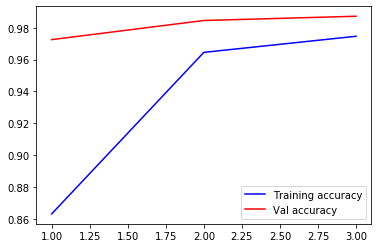

In [11]:
acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1, len(acc)+1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Val accuracy')
plt.legend()
plt.show()


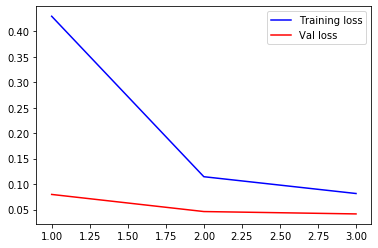

In [12]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1 )
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Val loss')
plt.legend()
plt.show()